# Title
*By: Jaeyoung Oh*

*GitHub: https://github.com/BlueJayVRStudio/DeepLearningFinal*

Lorem Ipsum Dolor...

notes though:
1. only remove outliers from training set (currently decided to use robust scaler instead of removing outliers, because we have way too many outliers, and those outliers are most likely meaningful.
2. only use interpolation on training set
3. only fit scaler on training set

In [636]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler

In [637]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

## Iterative Data Cleaning and EDA



### Import Dataset


In [638]:
# Import datasets
df = pd.read_csv('./Data/heart_failure_clinical_records_dataset.csv')
labels = df['DEATH_EVENT']
df = df.drop(columns=['DEATH_EVENT'])

In [639]:
X_train, X_test, y_train, y_test =  train_test_split(df, labels, test_size=0.2, random_state=42)

In [640]:
print(f" train feature set size: {len(X_train)},\n test feature set size: {len(X_test)},\n train label set size: {len(y_train)},\n test label set size: {len(y_test)},\n original data frame size: {len(df)}")

 train feature set size: 239,
 test feature set size: 60,
 train label set size: 239,
 test label set size: 60,
 original data frame size: 299


### Data Description

Lorem ipsum dolor...


In [641]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
 11  time                      239 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 24.3 KB


In [642]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
6,75.000,1,246,0,15,0,127000.00,1.20,137,1,0,10
183,75.000,0,99,0,38,1,224000.00,2.50,134,1,0,162
185,60.667,1,104,1,30,0,389000.00,1.50,136,1,0,171
146,52.000,0,132,0,30,0,218000.00,0.70,136,1,1,112
30,94.000,0,582,1,38,1,263358.03,1.83,134,1,0,27


In [643]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 239 entries, 6 to 102
Series name: DEATH_EVENT
Non-Null Count  Dtype
--------------  -----
239 non-null    int64
dtypes: int64(1)
memory usage: 3.7 KB


### Missing Values
In our data description we saw that there were no null values. But we'll double check here.

In [644]:
# there are 96 total null values
X_train.isna().sum().sum()

0

### Data distribution and analysis on "Time" feature

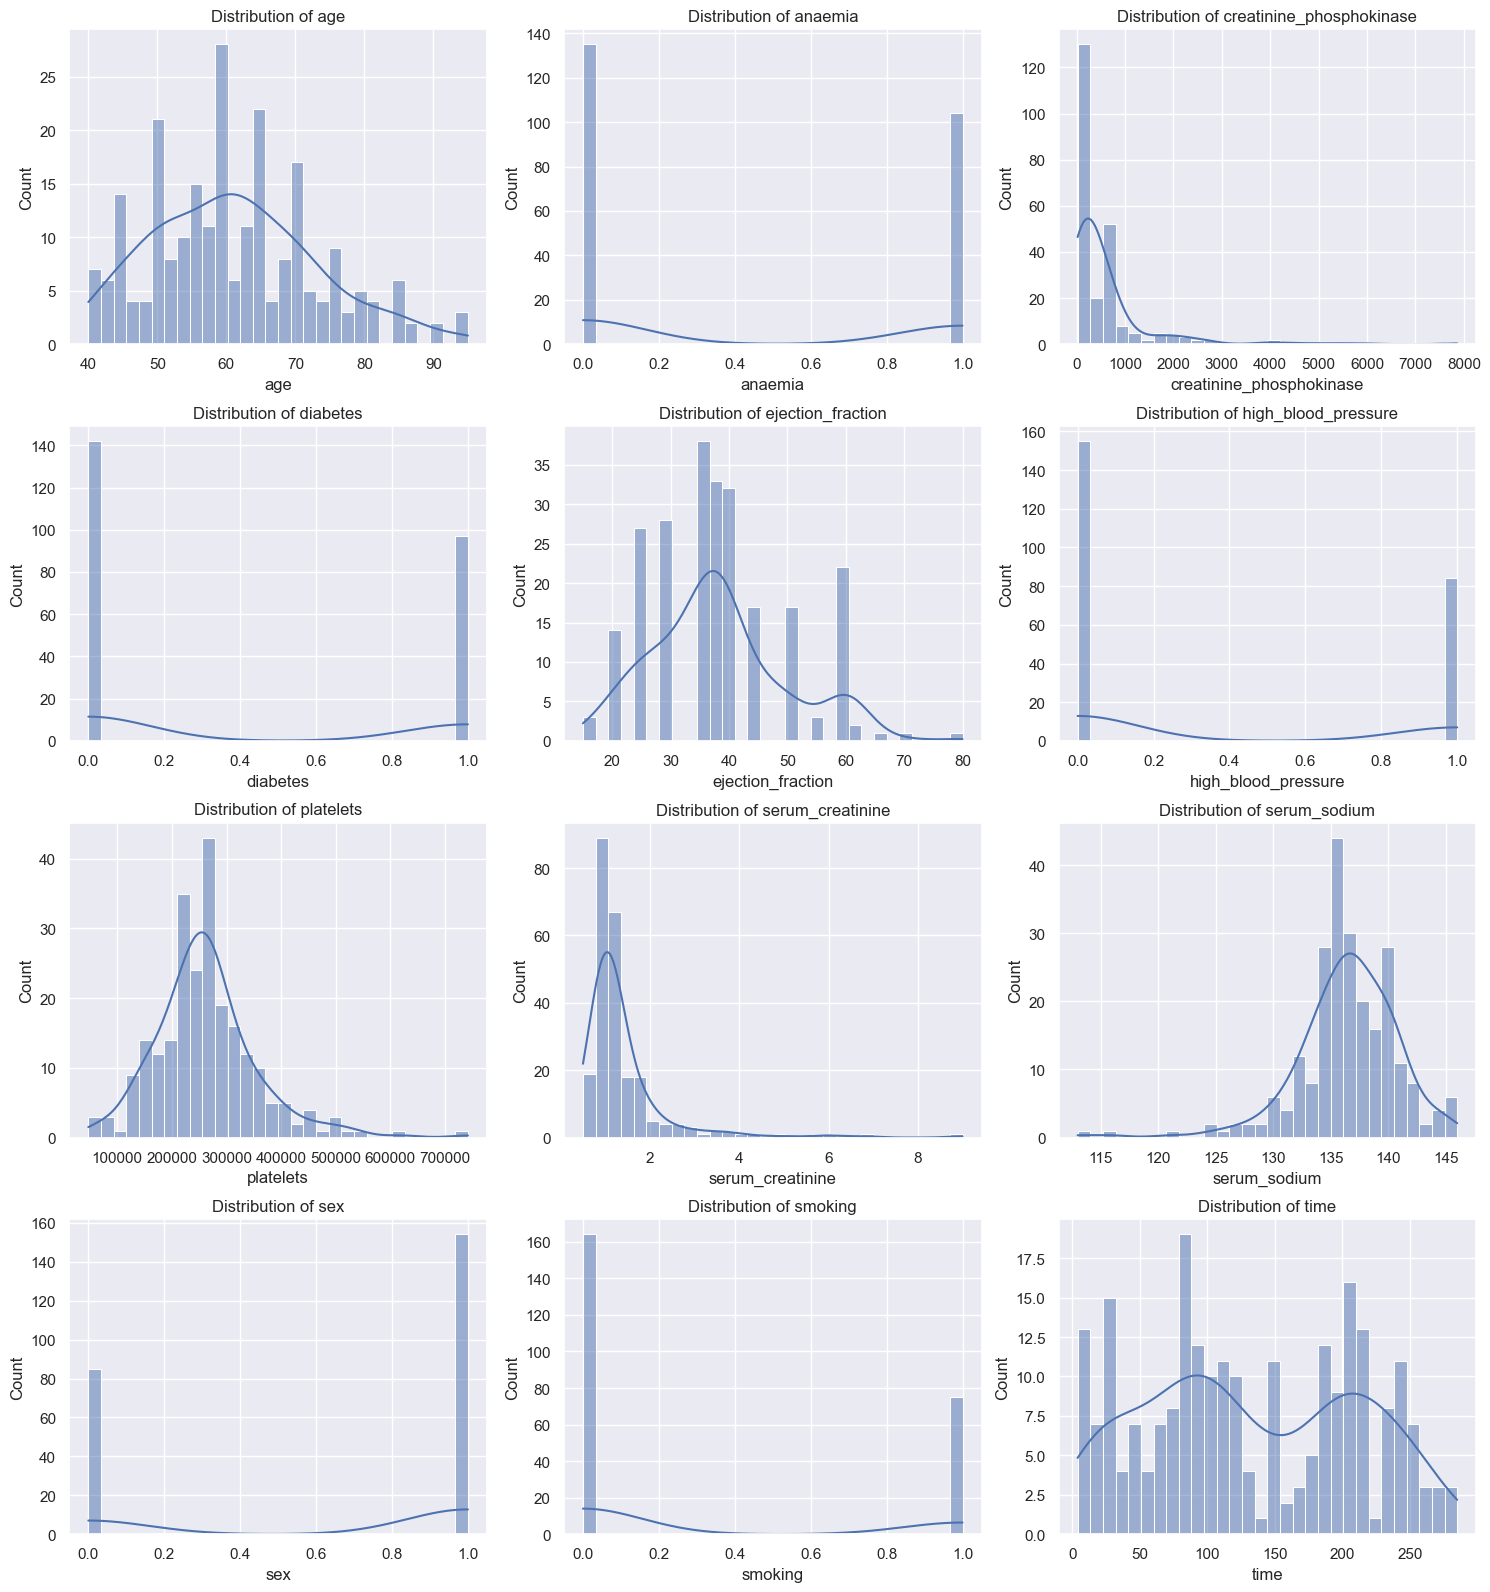

In [645]:
num_cols = len(X_train.columns)
rows, cols = math.ceil(num_cols / 3), min(3, num_cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for ax, col in zip(axes, X_train.columns):
    sns.histplot(X_train[col], bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')

# Hide unused subplots
for ax in axes[num_cols:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

Time could mean many different things even in medical records and unfortunately the author of this dataset has not elaborated on time. However, it's fairly reasonable to conclude that the time feature just means the time between the last follow-up exam and the heart failure event. In case the patient has passed, the time will indicate the time between the heart failure event and the death event. This is also evident in the bimodality of the time data distribution. The first peak, which has a lower mean time, correlates with the population of patients who have passed whereas the the second peak correlates with those who are still alive. Because this feature gives too strong of a predictive power, we will drop it from the dataset:

In [646]:
X_train = X_train.drop(columns=['time'])
X_test = X_test.drop(columns=['time'])

In [647]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Dealing with Outliers

Below are box plots for each feature in each dataset

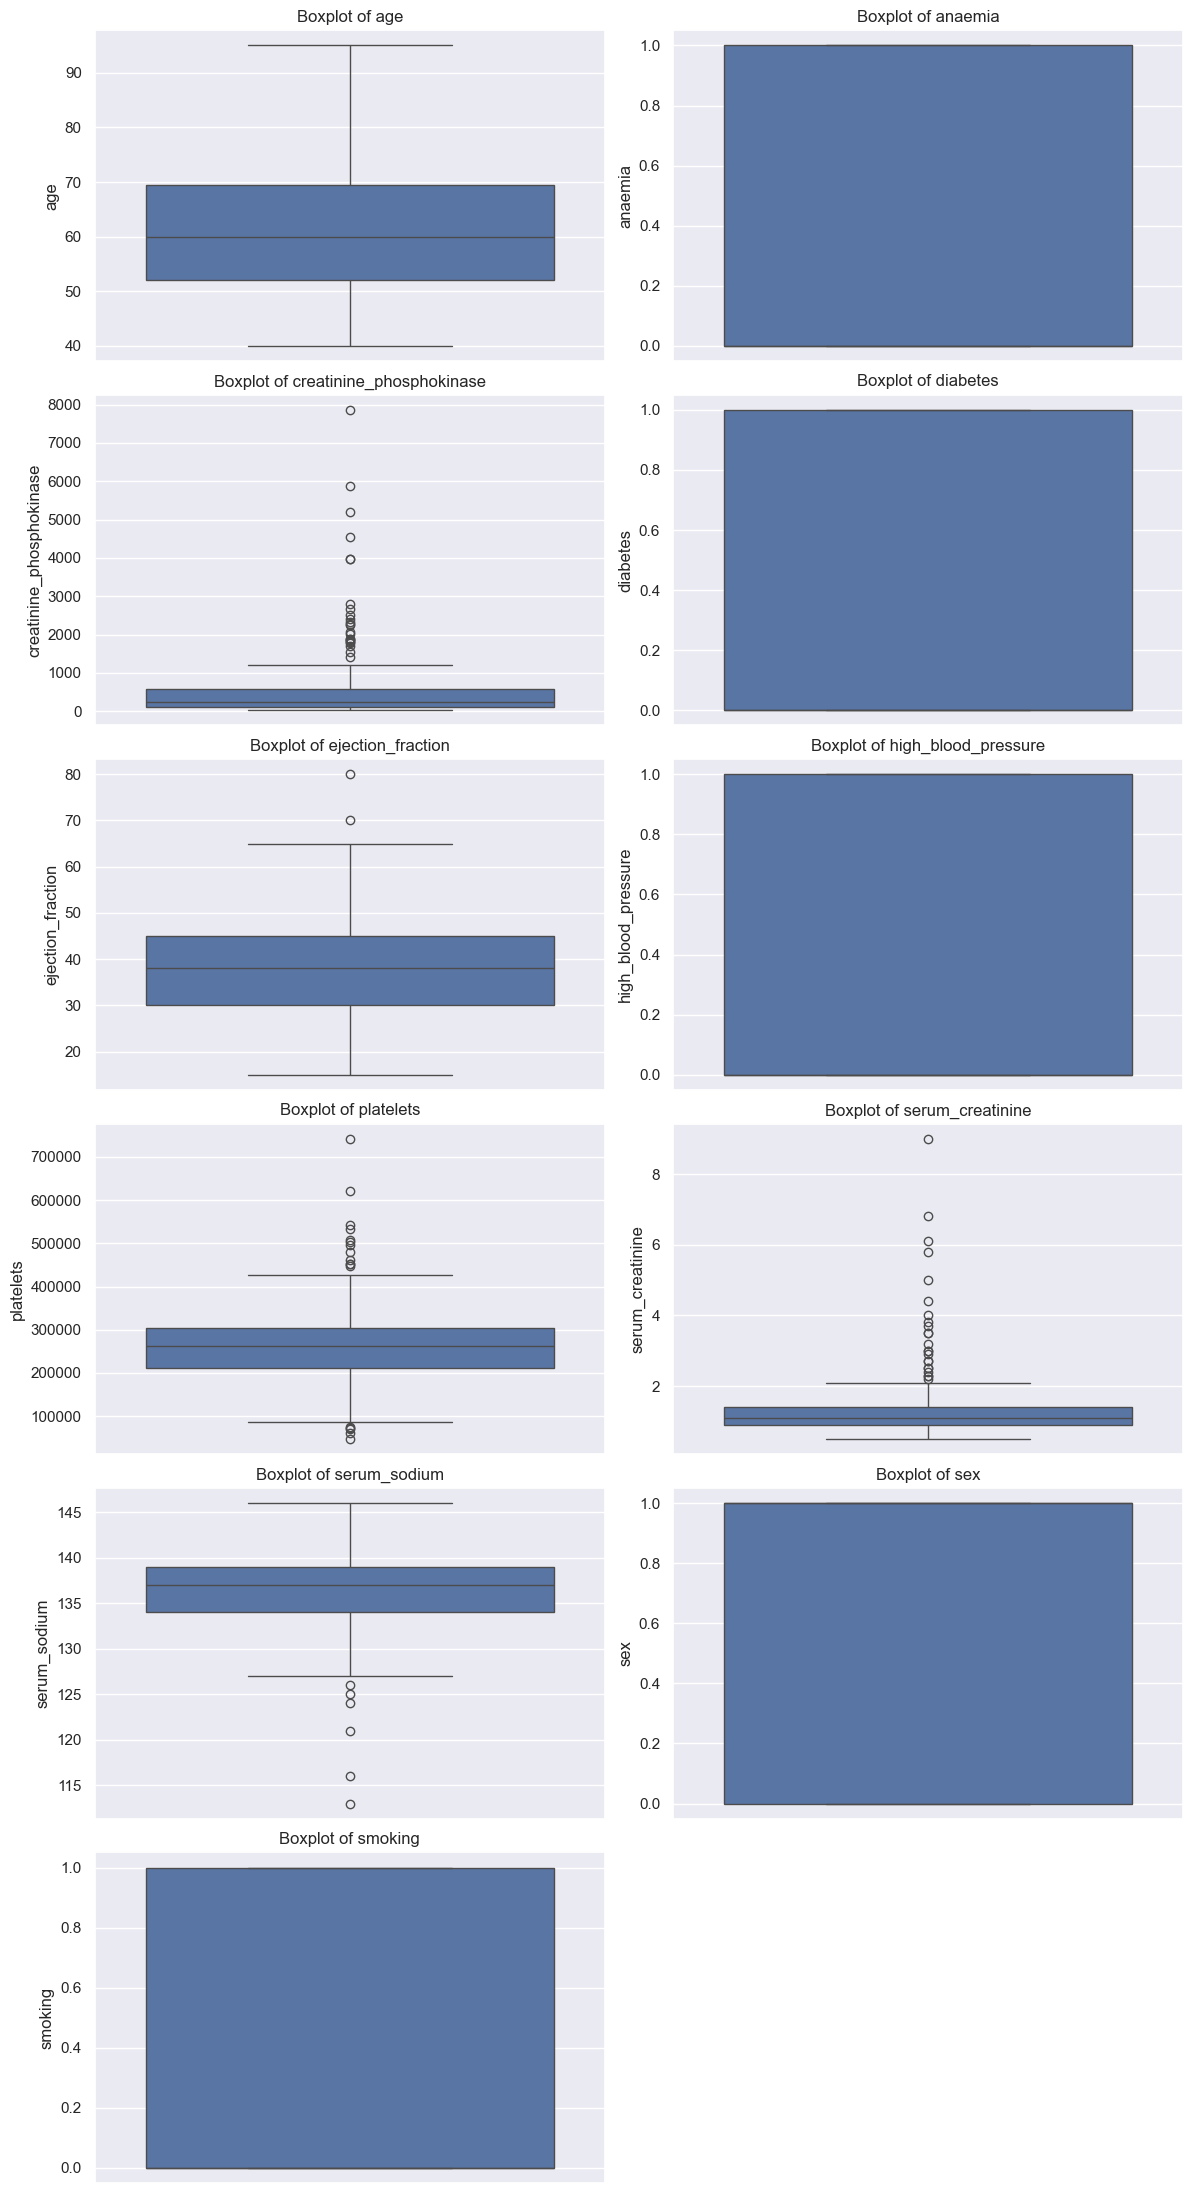

In [648]:
num_features = len(X_train.columns)

fig, axes = plt.subplots(nrows=(num_features // 2) + 1, ncols=2, figsize=(12, num_features * 2))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    sns.boxplot(y=X_train[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [649]:
Q1 = X_train['creatinine_phosphokinase'].quantile(0.25)
Q3 = X_train['creatinine_phosphokinase'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = X_train[(X_train['creatinine_phosphokinase'] < lower_bound) | (X_train['creatinine_phosphokinase'] > upper_bound)]
outliers

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
283,65.0,0,1688,0,38,0,263358.03,1.10,138,1,1
296,45.0,0,2060,1,60,0,742000.00,0.80,138,0,0
72,85.0,0,5882,0,35,0,243000.00,1.00,132,1,1
246,55.0,0,2017,0,25,0,314000.00,1.10,138,1,0
139,50.0,0,1548,0,30,1,211000.00,0.80,138,1,0
38,60.0,0,2656,1,30,0,305000.00,2.30,137,1,0
176,69.0,0,1419,0,40,0,105000.00,1.00,135,1,1
208,60.0,1,2281,1,40,0,283000.00,1.00,141,0,0
107,45.0,1,1876,1,35,0,226000.00,0.90,138,1,0
250,50.0,0,2522,0,30,1,404000.00,0.50,139,0,0


In [650]:
print(len(outliers))

24


We have way too many outliers for such a sparse dataset. That is 10% of the dataset from creatinine phosphokinase alone. We will opt to use robust scaler. Outliers may represent critical patients, so it most likely has significant information.

### Addressing multicollinearity

Because this project is mainly concerned with classification and the algorithms we will be using are robust against collinearity, there is not much justification to do thorough analysis of multicollinearity to drop some of the features. However, because of the large number of features present in our aggregate dataset, it would be preferred to drop some of the highly correlative features.

In [651]:
X_train.corr()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
age,1.000000,0.075484,-0.047069,-0.103526,0.020804,0.069992,0.000475,0.119166,-0.065063,0.063091,-0.032755
anaemia,0.075484,1.000000,-0.167715,-0.003595,0.028008,0.060945,-0.045011,0.018905,0.052352,-0.088370,-0.138876
creatinine_phosphokinase,-0.047069,-0.167715,1.000000,-0.063066,-0.013758,-0.120585,-0.011842,0.018959,0.079775,0.060299,0.052583
diabetes,-0.103526,-0.003595,-0.063066,1.000000,0.008377,-0.037337,0.086682,-0.043117,-0.135737,-0.169129,-0.154961
ejection_fraction,0.020804,0.028008,-0.013758,0.008377,1.000000,0.049641,0.084689,0.007005,0.170855,-0.119223,-0.078148
high_blood_pressure,0.069992,0.060945,-0.120585,-0.037337,0.049641,1.000000,0.030705,-0.039177,0.070915,-0.057220,-0.063454
platelets,0.000475,-0.045011,-0.011842,0.086682,0.084689,0.030705,1.000000,-0.069992,0.046123,-0.151702,-0.014396
serum_creatinine,0.119166,0.018905,0.018959,-0.043117,0.007005,-0.039177,-0.069992,1.000000,-0.221415,-0.041322,-0.088745
serum_sodium,-0.065063,0.052352,0.079775,-0.135737,0.170855,0.070915,0.046123,-0.221415,1.000000,-0.060037,0.013470
sex,0.063091,-0.088370,0.060299,-0.169129,-0.119223,-0.057220,-0.151702,-0.041322,-0.060037,1.000000,0.445903


<Axes: >

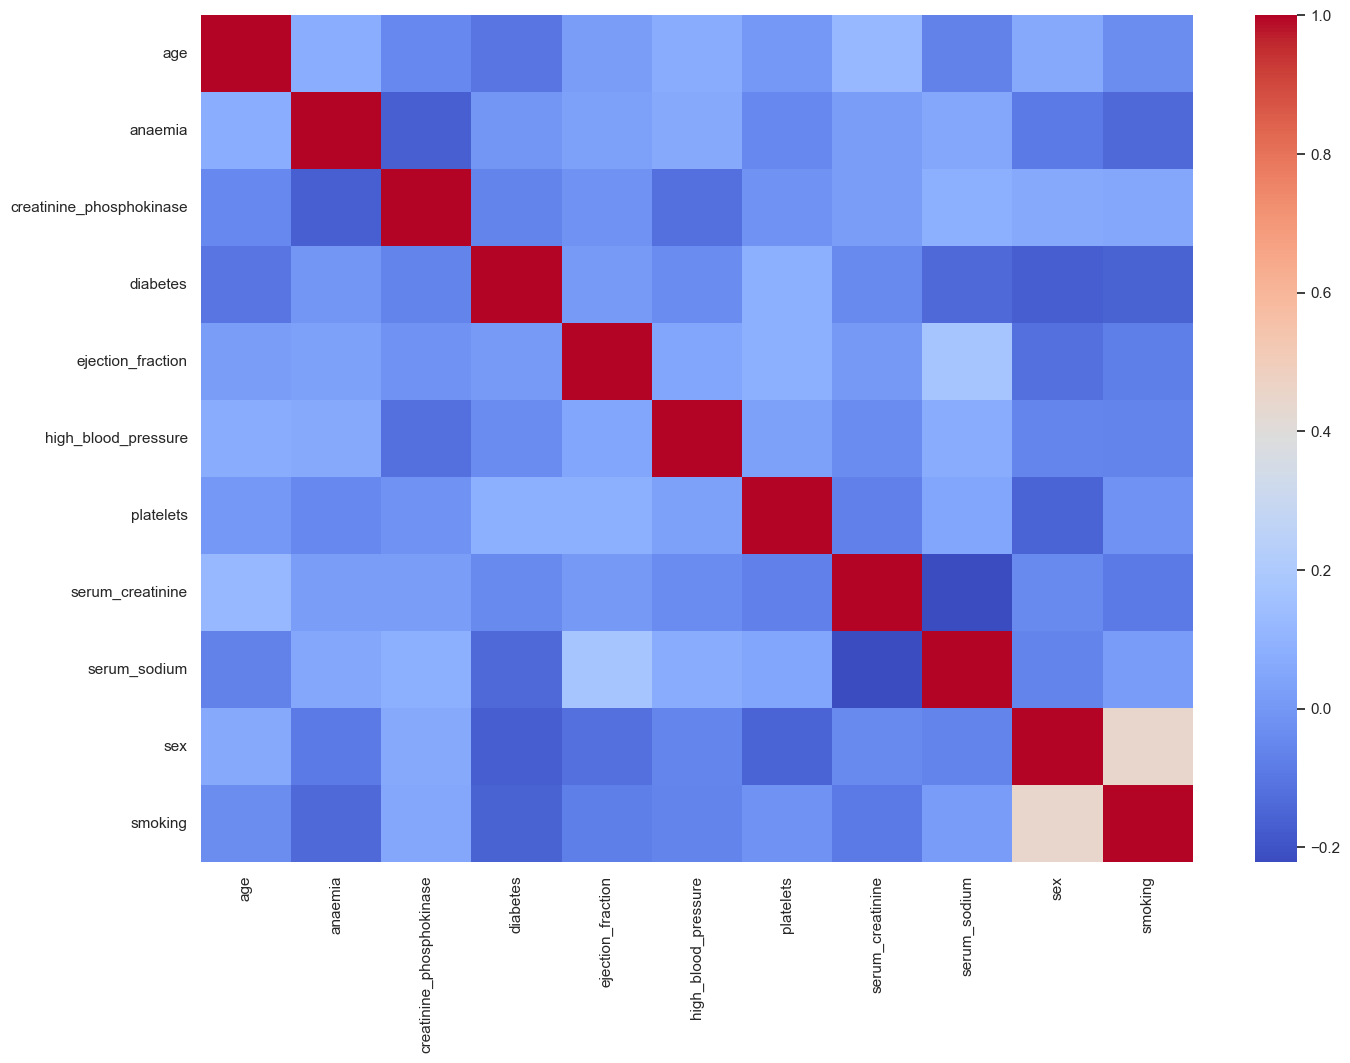

In [652]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm")

In [653]:
# We will drop features that have greater than 0.95 correlation but less than .99
# Make sure to only use train set
corr = X_train.corr().abs()

to_drop = set()

columns = corr.columns
for i in range(len(columns)):
    for j in range(i+1,len(columns)):
        if corr.iloc[i][j] > 0.95:
            to_drop.add(columns[i])
            print(corr.iloc[i][j])
            break
            
print(len(columns), len(to_drop))
print(list(to_drop))

X_train.drop(list(to_drop), axis=1, inplace=True)
X_test.drop(list(to_drop), axis=1, inplace=True)


11 0
[]


Fortunately there are no highly correlated features, meaning we will get to keep all the features that we currently have.

In [654]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 239 entries, 6 to 102
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       239 non-null    float64
 1   anaemia                   239 non-null    int64  
 2   creatinine_phosphokinase  239 non-null    int64  
 3   diabetes                  239 non-null    int64  
 4   ejection_fraction         239 non-null    int64  
 5   high_blood_pressure       239 non-null    int64  
 6   platelets                 239 non-null    float64
 7   serum_creatinine          239 non-null    float64
 8   serum_sodium              239 non-null    int64  
 9   sex                       239 non-null    int64  
 10  smoking                   239 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 22.4 KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 281 to 59
Data columns (total 11 columns):
 #   Column                  

### Checking imbalance


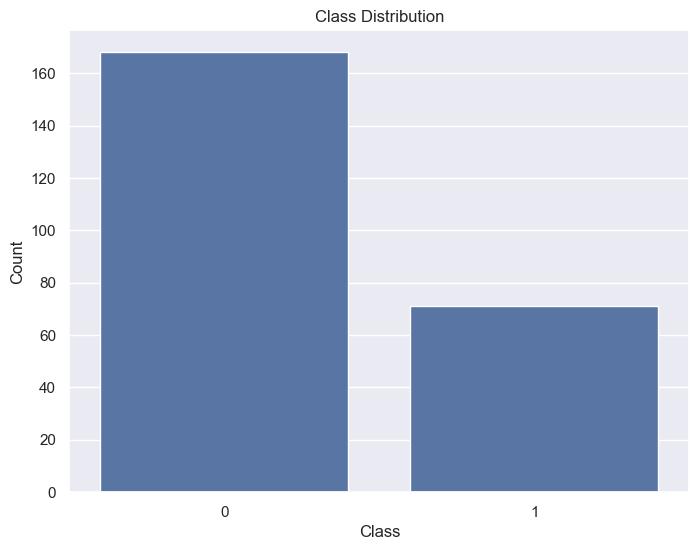

In [655]:
class_counts = y_train.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

We have to use smote to interpolate data for the minority class... It should come before feature scaling because smote works in the original feature space. Scaling the feature before may distort relationships among the new set of samples.

In [656]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [657]:
print(f" train feature set size: {len(X_train)},\n test feature set size: {len(X_test)},\n train label set size: {len(y_train)},\n test label set size: {len(y_test)},\n original data frame size: {len(df)}")

 train feature set size: 336,
 test feature set size: 60,
 train label set size: 336,
 test label set size: 60,
 original data frame size: 299


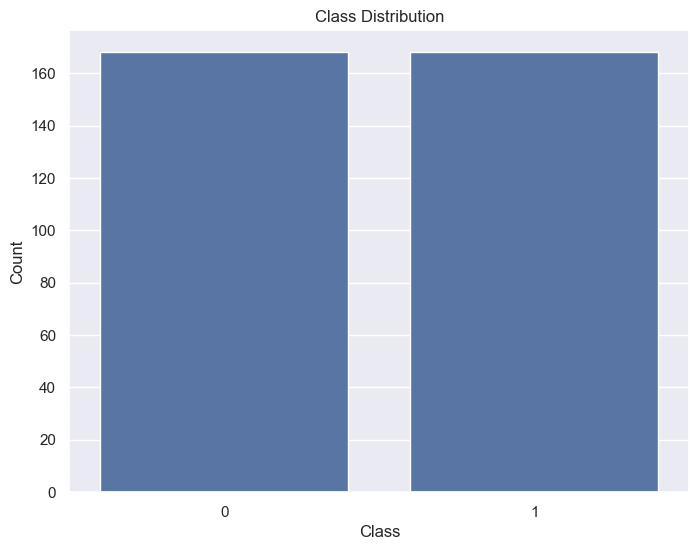

In [658]:
class_counts = y_train.value_counts()

# bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Feature Scaling

We will finalize the EDA by robust scaling. Make sure to scale both train and test but fit only on train

In [659]:
scaler = RobustScaler()

to_scale = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']

X_train_scaled = scaler.fit_transform(X_train[to_scale])
X_test_scaled = scaler.transform(X_test[to_scale])

In [660]:
X_train[to_scale] = X_train_scaled
X_test[to_scale] = X_test_scaled

In [661]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,0.859276,1,-0.026345,0,-1.632653,0,-1.233864,0.000000,0.2,1,0
1,0.859276,0,-0.349067,0,0.244898,1,-0.302971,1.881916,-0.4,1,0
2,-0.025914,1,-0.338090,1,-0.408163,0,1.280506,0.434288,0.0,1,0
3,-0.561179,0,-0.276619,0,-0.408163,0,-0.360552,-0.723814,0.0,1,1
4,2.032696,0,0.711306,1,0.244898,1,0.074741,0.912005,-0.4,1,0


In [662]:
X_test.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
281,0.550482,0,0.711306,0,0.408163,0,-1.963223,2.171441,0.0,1,1
265,-0.684697,1,0.087816,0,0.000000,0,1.021391,-0.434288,0.8,1,1
164,-0.993492,0,4.794731,1,-0.408163,0,0.752680,-0.144763,0.6,1,0
9,1.168071,1,-0.296378,0,0.000000,1,1.270909,11.870546,-0.6,1,1
77,-1.178768,0,-0.342481,1,0.408163,0,-0.178212,0.000000,0.8,1,0


### Data Cleaning and EDA Conclusion

Lorem ipsum dolor...

## Models

Lorem ipsum dolor...

In [978]:
# We will keep track of accuracy, precision and recall of each model for summary statistics
summary_stats = {
    'Model': [],
    'Train Accuracy': [],
    'Train Precision': [],
    'Train Recall': [],
    'Test Accuracy': [],
    'Test Precision': [],
    'Test Recall': [],
    'P-Value': [],
    'Is Significant': []
}

In [979]:
from sklearn.metrics import confusion_matrix
from helpers.metrics import *
from scipy import stats

def XOR(a, b):
    return (a and not b) or (not a and b)
    
# Generalized Statistics Handling. Probably bad practice, but notebook looks much cleaner :) Saved about a few hundreds of lines of code (?)
def handle_stats(predictor, _x_train, _x_test, _y_train, _y_test, model_name=None, _prediction=None, is_test=True, permute_labels=False):
    assert model_name is not None, "Please provide model name"
    assert XOR(predictor is not None, _prediction is not None), "Either provide a predictor or a prediction, and not both."
    
    ### Prepare predictions
    prediction = None
    if predictor is not None and is_test:
        prediction = predictor.predict(_x_test)
    elif predictor is not None and not is_test:
        prediction = predictor.predict(_x_train)
    else:
        prediction = _prediction
        
    ### Prepare labels
    labels = np.array(_y_test) if is_test else np.array(_y_train)

    ### Permute labels if necessary (for clustering methods)
    if permute_labels:
        labelorder, acc = label_permute_compare(labels, prediction)
        cluster_to_index = np.take(labelorder, prediction)
        prediction = np.take(unique_labels, cluster_to_index)

    print(f"Prediction: {prediction}, shape: {prediction.shape} \n")
    print(f"True Label: {labels}, shape: {labels.shape} \n")
    
    # Calculate Accuracy
    total = len(np.array(prediction == labels))
    correct = len(np.where(np.array(prediction == labels) == True)[0])
    accuracy = correct/total
    
    # Construct confusion matrix
    confusion_mat = confusion_matrix(labels, prediction)
    
    # Calculate Precision
    _precision = precision(confusion_mat)
    # Calculate Recall
    _recall = recall(confusion_mat)

    # Calculate p-value assuming binomial probability distribution for n = |label|
    p = 0.5
    n = len(labels)
    mean = p * n
    std = np.sqrt(n * p * (1-p))
    observed_accuracy = accuracy * n
    
    # Calculate the z-score
    z_score = (observed_accuracy - mean) / std
    
    # Calculate the p-value (two-tailed)
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    print(f"Z-Score: {z_score} \n")
    print(f"P-Value: {p_value} \n")
    
    summary_stats['P-Value'].append(p_value)
    summary_stats['Is Significant'].append(True) if p_value < 0.05 else summary_stats['Is Significant'].append(False)
    
    summary_stats['Model'].append(model_name)

    print(confusion_mat)

    ###
    prefix = "est" if is_test else "rain"
    antiprefix = "rain" if is_test else "est"
    
    print(f"t{prefix} accuracy: {accuracy}")
    print(f"t{prefix} precision: {_precision}")
    print(f"t{prefix} recall: {_recall}")

    summary_stats[f'T{prefix} Accuracy'].append(accuracy)
    summary_stats[f'T{prefix} Precision'].append(_precision)
    summary_stats[f'T{prefix} Recall'].append(_recall)
    summary_stats[f'T{antiprefix} Accuracy'].append(None)
    summary_stats[f'T{antiprefix} Precision'].append(None)
    summary_stats[f'T{antiprefix} Recall'].append(None)

### Linear kernel SVC

In [980]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(X_train, y_train)

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")


best params: {'C': 0.6270562047751306, 'loss': 'hinge'}
cross validation score: 0.7680035650623886


In [981]:
handle_stats(grid_linsvc.best_estimator_, X_train, X_test, y_train, y_test, model_name="Linear SVC", _prediction=None, is_test=True, permute_labels=False)

Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.0983866769659336 

P-Value: 0.0019457736937391612 

[[29  6]
 [12 13]]
test accuracy: 0.7
test precision: 0.6957637997432606
test recall: 0.6742857142857144


Lorem ipsum dolor...

In [982]:
summary_stats

{'Model': ['Linear SVC'],
 'Train Accuracy': [None],
 'Train Precision': [None],
 'Train Recall': [None],
 'Test Accuracy': [0.7],
 'Test Precision': [0.6957637997432606],
 'Test Recall': [0.6742857142857144],
 'P-Value': [0.0019457736937391612],
 'Is Significant': [True]}

### Simple ANN

In [748]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [1787]:
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=50,
    restore_best_weights=True
)

In [1788]:
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
21/21 [==============================] - 1s 8ms/step - loss: 0.6980 - accuracy: 0.5208 - val_loss: 0.6899 - val_accuracy: 0.6000
Epoch 2/500
21/21 [==============================] - 0s 2ms/step - loss: 0.6803 - accuracy: 0.6518 - val_loss: 0.6790 - val_accuracy: 0.6167
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.7262 - val_loss: 0.6540 - val_accuracy: 0.6167
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 0.6016 - accuracy: 0.7738 - val_loss: 0.6182 - val_accuracy: 0.7167
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.5298 - accuracy: 0.7798 - val_loss: 0.6202 - val_accuracy: 0.6833
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4730 - accuracy: 0.7827 - val_loss: 0.6422 - val_accuracy: 0.6667
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4420 - accuracy: 0.7917 - val_loss: 0.6478 - val_accuracy: 0.7000
Epoch 8/500
2

In [1789]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print(test_loss, test_acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6182 - accuracy: 0.7167
0.6181685328483582 0.7166666388511658


### ANN + Autoencoder

In [1701]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

class Autoencoder(Model):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # ENCODER
        self.encoder = keras.Sequential([
            keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(encoding_dim, activation='relu')
        ])

        # DECODER
        self.decoder = keras.Sequential([
            keras.layers.Dense(input_dim//2, activation='relu', input_shape=(encoding_dim,)),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(input_dim, activation='relu'),
            keras.layers.Dense(input_dim, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        reconstructed = self.decoder(encoded)
        return reconstructed
        
num_features = X_train.shape[1]
encoding_dim = 6
autoencoder = Autoencoder(num_features, encoding_dim)

# optimizer = tf.keras.optimizers.Adam()
optimizer = Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

def train_autoencoder(model, X_train, X_test, epochs=50, batch_size=16):
    dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # training step
        for batch in dataset:
            with tf.GradientTape() as tape:
                reconstructed = model(batch)
                loss = loss_fn(batch, reconstructed)
            
            # compute gradients and update weights
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += loss.numpy()

        # calculate validation loss
        val_reconstructed = model(X_test)
        val_loss = loss_fn(X_test, val_reconstructed).numpy()

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

train_autoencoder(autoencoder, np.array(X_train), np.array(X_test), epochs=500, batch_size=100)

X_train_encoded = autoencoder.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder.encoder(np.array(X_test)).numpy()

test_reconstructed = autoencoder(np.array(X_test))
test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")

Epoch 1/500 - Loss: 4.5459 - Val Loss: 1.2310
Epoch 2/500 - Loss: 4.4941 - Val Loss: 1.2167
Epoch 3/500 - Loss: 4.4084 - Val Loss: 1.1946
Epoch 4/500 - Loss: 4.2789 - Val Loss: 1.1742
Epoch 5/500 - Loss: 4.1479 - Val Loss: 1.1625
Epoch 6/500 - Loss: 4.0474 - Val Loss: 1.1449
Epoch 7/500 - Loss: 3.9536 - Val Loss: 1.1323
Epoch 8/500 - Loss: 3.8993 - Val Loss: 1.1233
Epoch 9/500 - Loss: 3.8585 - Val Loss: 1.1112
Epoch 10/500 - Loss: 3.8197 - Val Loss: 1.0996
Epoch 11/500 - Loss: 3.7881 - Val Loss: 1.0906
Epoch 12/500 - Loss: 3.7645 - Val Loss: 1.0849
Epoch 13/500 - Loss: 3.7474 - Val Loss: 1.0822
Epoch 14/500 - Loss: 3.7339 - Val Loss: 1.0792
Epoch 15/500 - Loss: 3.7205 - Val Loss: 1.0761
Epoch 16/500 - Loss: 3.7059 - Val Loss: 1.0732
Epoch 17/500 - Loss: 3.6873 - Val Loss: 1.0701
Epoch 18/500 - Loss: 3.6709 - Val Loss: 1.0671
Epoch 19/500 - Loss: 3.6570 - Val Loss: 1.0647
Epoch 20/500 - Loss: 3.6452 - Val Loss: 1.0615
Epoch 21/500 - Loss: 3.6313 - Val Loss: 1.0588
Epoch 22/500 - Loss: 3

In [1702]:
X_train_encoded = autoencoder.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder.encoder(np.array(X_test)).numpy()

In [1703]:
X_train_encoded

array([[ 0.       , 22.13875  ,  8.103673 , 22.943409 , 10.685002 ,
        27.229969 ],
       [ 0.       , 15.534206 ,  7.899452 ,  6.2607718,  4.5959625,
         9.191066 ],
       [ 0.       ,  1.6627023,  0.       ,  2.000293 ,  2.4127712,
         2.309994 ],
       ...,
       [ 0.       , 28.14677  , 12.462517 , 10.088518 , 12.916719 ,
        14.291453 ],
       [ 0.       , 10.88855  ,  5.474343 , 16.18503  ,  1.1497321,
        19.545074 ],
       [ 0.       , 18.789948 ,  8.187307 , 17.873535 ,  6.7739177,
        21.911709 ]], dtype=float32)

In [1704]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [1705]:
print(len(X_train), len(X_train_augmented))
print(len(X_test), len(X_test_augmented))

336 336
60 60


In [1820]:
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=50,
    restore_best_weights=True
)

In [1821]:
history = model.fit(
    X_train_augmented, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
21/21 [==============================] - 1s 8ms/step - loss: 0.6381 - accuracy: 0.6190 - val_loss: 0.6862 - val_accuracy: 0.6000
Epoch 2/500
21/21 [==============================] - 0s 2ms/step - loss: 0.5704 - accuracy: 0.6994 - val_loss: 0.6404 - val_accuracy: 0.7000
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 0.5304 - accuracy: 0.7440 - val_loss: 0.6261 - val_accuracy: 0.6167
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 0.5060 - accuracy: 0.7589 - val_loss: 0.7264 - val_accuracy: 0.6333
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4780 - accuracy: 0.7798 - val_loss: 0.6065 - val_accuracy: 0.7500
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4646 - accuracy: 0.8065 - val_loss: 0.6842 - val_accuracy: 0.6333
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4794 - accuracy: 0.8006 - val_loss: 0.6112 - val_accuracy: 0.7167
Epoch 8/500
2

In [1822]:
test_loss, test_acc = model.evaluate(X_test_augmented, y_test, verbose=1)

print(test_loss, test_acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6459 - accuracy: 0.7667
0.6459448337554932 0.7666666507720947


### Linear SVC with the encoded data

In [1823]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

parameters = {'loss': ['hinge', 'squared_hinge'],
              'C':np.logspace(-2, 0, 301, base=2)}
svc = LinearSVC(random_state=1)
grid_linsvc = GridSearchCV(svc, parameters, cv=10, n_jobs=-1, scoring='accuracy')

grid_linsvc.fit(np.array(X_train_augmented), np.array(y_train))

best_params = grid_linsvc.best_params_
best_score = grid_linsvc.best_score_

print(f"best params: {best_params}")
print(f"cross validation score: {best_score}")


best params: {'C': 0.25, 'loss': 'squared_hinge'}
cross validation score: 0.7861853832442068


In [1824]:
handle_stats(grid_linsvc.best_estimator_, np.array(X_train_augmented), np.array(X_test_augmented), y_train, y_test, model_name="Linear SVC with encoding", _prediction=None, is_test=True, permute_labels=False)

Prediction: [1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0
 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1], shape: (60,) 

True Label: [0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1], shape: (60,) 

Z-Score: 3.3565855667130946 

P-Value: 0.0007891129890156279 

[[28  7]
 [10 15]]
test accuracy: 0.7166666666666667
test precision: 0.7093301435406698
test recall: 0.7


Lorem ipsum dolor...

In [1825]:
summary_stats

{'Model': ['Linear SVC',
  'Linear SVC',
  'Linear SVC with encoding',
  'Linear SVC with encoding',
  'Linear SVC with encoding'],
 'Train Accuracy': [None, None, None, None, None],
 'Train Precision': [None, None, None, None, None],
 'Train Recall': [None, None, None, None, None],
 'Test Accuracy': [0.7, 0.7, 0.7, 0.6333333333333333, 0.7166666666666667],
 'Test Precision': [0.6957637997432606,
  0.6957637997432606,
  0.6957637997432606,
  0.6187419768934532,
  0.7093301435406698],
 'Test Recall': [0.6742857142857144,
  0.6742857142857144,
  0.6742857142857144,
  0.6057142857142858,
  0.7],
 'P-Value': [0.0019457736937391612,
  0.0019457736937391612,
  0.0019457736937391612,
  0.038867103812417314,
  0.0007891129890156279],
 'Is Significant': [True, True, True, True, True]}

### Orthogonality enforced autoencoder

reference: Jaehoon Cha and Jeyan Thiyagalingam. 2023. Orthogonality-enforced latent space in autoencoders: an approach to learning disentangled representations. In Proceedings of the 40th International Conference on Machine Learning (ICML'23), Vol. 202. JMLR.org, Article 157, 3913–3948.


In [1826]:
class AutoencoderOrtho(Model):
    def __init__(self, input_dim, encoding_dim):
        super(AutoencoderOrtho, self).__init__()

        # ENCODER
        self.encoder = keras.Sequential([
            keras.layers.Dense(input_dim, activation='relu', input_shape=(input_dim,)),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(encoding_dim, activation='relu')
        ])

        # DECODER
        self.decoder = keras.Sequential([
            keras.layers.Dense(input_dim//2, activation='relu', input_shape=(encoding_dim,)),
            keras.layers.Dense(input_dim//2, activation='relu'),
            keras.layers.Dense(input_dim, activation='relu'),
            keras.layers.Dense(input_dim, activation='sigmoid')
        ])
        

    def call(self, inputs):
        encoded = self.encoder(inputs)
        reconstructed = self.decoder(encoded)
        return reconstructed


num_features = X_train.shape[1]
encoding_dim = 6
autoencoder_ortho = AutoencoderOrtho(num_features, encoding_dim)

# optimizer = tf.keras.optimizers.Adam()
optimizer = Adam(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()
        
def orthogonality_loss(z):
    z_t = tf.transpose(z)
    z_product = tf.matmul(z_t, z)
    identity = tf.eye(z_product.shape[0])
    ortho_loss = tf.reduce_mean(tf.square(z_product - identity))

    # print(z.shape, z_t.shape, z_product.shape, identity.shape)
    # print("ortho loss: ", ortho_loss)
    return ortho_loss

def train_autoencoder_ortho(model, X_train, X_test, epochs=50, batch_size=16, lambda_ortho=0.5):
    dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # training step
        for batch in dataset:
            with tf.GradientTape() as tape:
                reconstructed = model(batch)
                reconstruction_loss = loss_fn(batch, reconstructed)
                
                z = model.encoder(batch)
                ortho_loss = orthogonality_loss(z)
                
                total_loss = reconstruction_loss + lambda_ortho * ortho_loss
            
            # compute gradients and update weights
            grads = tape.gradient(total_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            epoch_loss += total_loss.numpy()

        # calculate validation loss
        val_reconstructed = model(X_test)
        val_loss = loss_fn(X_test, val_reconstructed).numpy()

        test_z = model.encoder(X_test)
        val_loss += orthogonality_loss(test_z)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}")

train_autoencoder_ortho(autoencoder_ortho, np.array(X_train), np.array(X_test), epochs=500, batch_size=100, lambda_ortho=0.1)

test_reconstructed = autoencoder_ortho(np.array(X_test))
test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")

Epoch 1/500 - Loss: 6.6295 - Val Loss: 1.3902
Epoch 2/500 - Loss: 4.5591 - Val Loss: 1.3615
Epoch 3/500 - Loss: 4.5005 - Val Loss: 1.3445
Epoch 4/500 - Loss: 4.4334 - Val Loss: 1.3274
Epoch 5/500 - Loss: 4.3518 - Val Loss: 1.3082
Epoch 6/500 - Loss: 4.2667 - Val Loss: 1.2884
Epoch 7/500 - Loss: 4.2007 - Val Loss: 1.2806
Epoch 8/500 - Loss: 4.1578 - Val Loss: 1.2814
Epoch 9/500 - Loss: 4.1422 - Val Loss: 1.2829
Epoch 10/500 - Loss: 4.1359 - Val Loss: 1.2797
Epoch 11/500 - Loss: 4.1269 - Val Loss: 1.2738
Epoch 12/500 - Loss: 4.1124 - Val Loss: 1.2668
Epoch 13/500 - Loss: 4.0943 - Val Loss: 1.2591
Epoch 14/500 - Loss: 4.0716 - Val Loss: 1.2534
Epoch 15/500 - Loss: 4.0497 - Val Loss: 1.2495
Epoch 16/500 - Loss: 4.0283 - Val Loss: 1.2475
Epoch 17/500 - Loss: 4.0060 - Val Loss: 1.2463
Epoch 18/500 - Loss: 3.9834 - Val Loss: 1.2455
Epoch 19/500 - Loss: 3.9607 - Val Loss: 1.2443
Epoch 20/500 - Loss: 3.9389 - Val Loss: 1.2437
Epoch 21/500 - Loss: 3.9176 - Val Loss: 1.2411
Epoch 22/500 - Loss: 3

In [1827]:
X_train_encoded = autoencoder_ortho.encoder(np.array(X_train)).numpy()
X_test_encoded = autoencoder_ortho.encoder(np.array(X_test)).numpy()

In [1828]:
X_train_encoded

array([[0.        , 0.        , 0.        , 0.0524722 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.15378918,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.02238434,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , 0.        , 0.21703069,
        0.        ],
       [0.        , 0.        , 0.        , 0.06622418, 0.3059172 ,
        0.        ],
       [0.        , 0.        , 0.        , 0.05609045, 0.06050175,
        0.        ]], dtype=float32)

In [1829]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [1830]:
print(len(X_train), len(X_train_augmented))
print(len(X_test), len(X_test_augmented))

336 336
60 60


In [1855]:
model = keras.Sequential([
    keras.layers.Dense(num_features*2, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(num_features*2, activation='relu'),
    keras.layers.Dense(num_features, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=50,
    restore_best_weights=True
)

In [1856]:
history = model.fit(
    X_train_augmented, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
21/21 [==============================] - 1s 8ms/step - loss: 0.6051 - accuracy: 0.6935 - val_loss: 0.6196 - val_accuracy: 0.7000
Epoch 2/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.7976 - val_loss: 0.6659 - val_accuracy: 0.6667
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4333 - accuracy: 0.8065 - val_loss: 0.7537 - val_accuracy: 0.6333
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4220 - accuracy: 0.8274 - val_loss: 0.7474 - val_accuracy: 0.6833
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4185 - accuracy: 0.8095 - val_loss: 0.7574 - val_accuracy: 0.6667
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3713 - accuracy: 0.8333 - val_loss: 0.7878 - val_accuracy: 0.6833
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3368 - accuracy: 0.8690 - val_loss: 0.8256 - val_accuracy: 0.6833
Epoch 8/500
2

In [1857]:
test_loss, test_acc = model.evaluate(X_test_augmented, y_test, verbose=1)

print(test_loss, test_acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6196 - accuracy: 0.7000
0.6195902228355408 0.699999988079071


### Variational Autoencoder

In [1968]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

encoding_dim = X_train.shape[1]//2
input_dim = X_train.shape[1]
batch_size = 32
learning_rate = 0.001
 
# ENCODER
class Encoder_VAE(tf.keras.Model):
    def __init__(self, encoding_dim, input_dim):
        super(Encoder_VAE, self).__init__()
        self.dense1 = layers.Dense(input_dim*2, activation='relu')
        self.dense2 = layers.Dense(input_dim, activation='relu')
        self.fc_mu = layers.Dense(encoding_dim)
        self.fc_logvar = layers.Dense(encoding_dim)
    
    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        mu = self.fc_mu(x)
        log_var = self.fc_logvar(x)
        return mu, log_var

# Sampling / Reparameterization "Trick"
def reparameterize(mu, log_var):
    epsilon = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(0.5 * log_var) * epsilon

# DECODER
class Decoder_VAE(tf.keras.Model):
    def __init__(self, encoding_dim, input_dim):
        super(Decoder_VAE, self).__init__()
        self.dense1 = layers.Dense(input_dim, activation='relu')
        self.dense2 = layers.Dense(input_dim*2, activation='relu')
        self.output_layer = layers.Dense(input_dim, activation='sigmoid')
    
    def call(self, z):
        x = self.dense1(z)
        x = self.dense2(x)
        return self.output_layer(x)

# Loss Function
def compute_loss_VAE(x, x_recon, mu, log_var):
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(x, x_recon))
    kl_divergence = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return reconstruction_loss + kl_divergence

# Instantiate Models:
encoder = Encoder_VAE(encoding_dim, input_dim)
decoder = Decoder_VAE(encoding_dim, input_dim)
optimizer = tf.keras.optimizers.Adam(learning_rate)

# TRAIN LOOPS
def train_VAE(dataset, epochs=50):
    dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batch_size)
    
    for epoch in range(epochs):
        total_loss = 0
        for step, batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                mu, log_var = encoder(batch)
                z = reparameterize(mu, log_var)
                reconstructed = decoder(z)
                loss = compute_loss_VAE(batch, reconstructed, mu, log_var)
            
            gradients = tape.gradient(loss, encoder.trainable_variables + decoder.trainable_variables)
            optimizer.apply_gradients(zip(gradients, encoder.trainable_variables + decoder.trainable_variables))
        
            total_loss += loss
            
        print(f"Epoch {epoch + 1}, Loss: {total_loss / (step + 1):.4f}")

# Train the VAE
train_VAE(X_train, epochs=250)

mu, log_var = encoder(np.array(X_test))
z = reparameterize(mu, log_var)
test_reconstructed = decoder(z)

test_loss = loss_fn(np.array(X_test), test_reconstructed).numpy()
print(f"\nTest Reconstruction Loss: {test_loss:.4f}")


Epoch 1, Loss: 1.4337
Epoch 2, Loss: 1.2842
Epoch 3, Loss: 1.2116
Epoch 4, Loss: 1.1622
Epoch 5, Loss: 1.1310
Epoch 6, Loss: 1.1050
Epoch 7, Loss: 1.0902
Epoch 8, Loss: 1.0711
Epoch 9, Loss: 1.0637
Epoch 10, Loss: 1.0516
Epoch 11, Loss: 1.0356
Epoch 12, Loss: 1.0316
Epoch 13, Loss: 1.0210
Epoch 14, Loss: 1.0149
Epoch 15, Loss: 1.0094
Epoch 16, Loss: 1.0073
Epoch 17, Loss: 1.0032
Epoch 18, Loss: 0.9986
Epoch 19, Loss: 0.9978
Epoch 20, Loss: 1.0019
Epoch 21, Loss: 0.9946
Epoch 22, Loss: 0.9933
Epoch 23, Loss: 0.9895
Epoch 24, Loss: 0.9804
Epoch 25, Loss: 0.9848
Epoch 26, Loss: 0.9822
Epoch 27, Loss: 0.9785
Epoch 28, Loss: 0.9869
Epoch 29, Loss: 0.9859
Epoch 30, Loss: 0.9852
Epoch 31, Loss: 0.9802
Epoch 32, Loss: 0.9800
Epoch 33, Loss: 0.9833
Epoch 34, Loss: 0.9756
Epoch 35, Loss: 0.9787
Epoch 36, Loss: 0.9740
Epoch 37, Loss: 0.9745
Epoch 38, Loss: 0.9800
Epoch 39, Loss: 0.9859
Epoch 40, Loss: 0.9779
Epoch 41, Loss: 0.9768
Epoch 42, Loss: 0.9822
Epoch 43, Loss: 0.9749
Epoch 44, Loss: 0.96

In [1969]:
mu, log_var = encoder(np.array(X_train))
z_train = reparameterize(mu, log_var)

mu, log_var = encoder(np.array(X_test))
z_test = reparameterize(mu, log_var)

In [1970]:
X_train_encoded = z_train.numpy()
X_test_encoded = z_test.numpy()

In [1971]:
X_train_encoded

array([[-0.84052676,  0.05045312, -1.8116088 , -1.3199408 , -0.57552576],
       [-1.3355163 ,  0.90674376,  0.05774317,  0.6389415 ,  1.2383928 ],
       [ 0.6938872 ,  0.26479176, -0.01802443,  0.00738659, -1.2397443 ],
       ...,
       [-0.03880796,  0.8073638 , -1.3986868 ,  2.451313  ,  0.16470341],
       [ 0.63062406,  0.42957604,  1.428327  , -1.5347188 ,  1.3094229 ],
       [-0.23611106,  0.6279814 ,  0.8540007 ,  1.0729666 , -0.10035373]],
      dtype=float32)

In [1972]:
X_train_augmented = pd.concat([X_train,  pd.DataFrame(X_train_encoded)], axis=1)
X_test_augmented = pd.concat([X_test.reset_index(drop=True),  pd.DataFrame(X_test_encoded)], axis=1)

In [1973]:
print(len(X_train), len(X_train_augmented))
print(len(X_test), len(X_test_augmented))

336 336
60 60


In [1974]:
model = keras.Sequential([
    keras.layers.Dense(num_features*2, activation='relu', input_shape=(X_train_augmented.shape[1],)),
    keras.layers.Dense(num_features*2, activation='relu'),
    keras.layers.Dense(num_features, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=50,
    restore_best_weights=True
)

In [1975]:
history = model.fit(
    X_train_augmented, y_train,
    epochs=500,
    batch_size=16,
    validation_data=(X_test_augmented, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/500
21/21 [==============================] - 1s 7ms/step - loss: 0.6186 - accuracy: 0.6756 - val_loss: 0.6116 - val_accuracy: 0.6500
Epoch 2/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.7560 - val_loss: 0.6531 - val_accuracy: 0.6667
Epoch 3/500
21/21 [==============================] - 0s 2ms/step - loss: 0.4348 - accuracy: 0.8214 - val_loss: 0.6809 - val_accuracy: 0.6500
Epoch 4/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3825 - accuracy: 0.8274 - val_loss: 0.7374 - val_accuracy: 0.6167
Epoch 5/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3354 - accuracy: 0.8482 - val_loss: 0.7859 - val_accuracy: 0.6333
Epoch 6/500
21/21 [==============================] - 0s 2ms/step - loss: 0.3095 - accuracy: 0.8542 - val_loss: 0.8897 - val_accuracy: 0.6167
Epoch 7/500
21/21 [==============================] - 0s 2ms/step - loss: 0.2822 - accuracy: 0.8869 - val_loss: 0.8830 - val_accuracy: 0.6500
Epoch 8/500
2

In [1976]:
test_loss, test_acc = model.evaluate(X_test_augmented, y_test, verbose=1)

print(test_loss, test_acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6531 - accuracy: 0.6667
0.6530829071998596 0.6666666865348816


# Results and Analysis

### Summary Statistics

We summarize the performance of various models, using precision, recall, and accuracy as the primary metrics for evaluation. Additionally we iterated through the hyperparameter tuning process for each model, using GridSearchCV with 10-fold cross-validation to ensure the best possible performance.

A comparison of the models based on the validation set is provided in the table below. The results show that the ensemble voting method achieved the highest accuracy of 87.50%, outperforming individual models such as Linear SVC, Logistic Regression, and MLPClassifier [[2](#References)][[3](#References)].

In [382]:
# Summary Stats
summarystats = pd.DataFrame(summary_stats)
summarystats.round(2)

,Model,Train Accuracy,Train Precision,Train Recall,Test Accuracy,Test Precision,Test Recall,P-Value,Is Significant
0,Linear SVC,None,None,None,0.7,0.69,0.69,0.0,True


### Hyperparameter Tuning and Cross Validation
* Grid search with 10-fold cross validation (5-fold for MLP) was employed for each model to find the optimal hyperparameters.
* For RBF SVC, C vs. gamma heatmap was used to visualize and aid in locating the best combination of parameters.
* For Random Forest number of estimators were plotted against train and test scores to identify points of diminishing return to optimize hyperparameters for grid search. Similar strategy was used for AdaBoost with Decision Tree stumps.

### Ensemble (Multi-Classifier) Voting Surprise Result

Incorporating KNN model, despite its low individual accuracy, into the ensemble voting method significantly improved overall accuracy, precision and recall. This suggests that the KNN model may have captured complementary patterns in the data, which enhanced the diversity of predictions and improved the robustness of the ensemble.


# Discussion and Conclusion

Lorem ipsum dolor. Some of the key takeaways include:
>1. **Lorem ipsum**: dolor


### Underperforming Models

Lorem ipsum dolor...

### Future Improvements
>1. 


### References
[1] Jaehoon Cha and Jeyan Thiyagalingam. 2023. Orthogonality-enforced latent space in autoencoders: an approach to learning disentangled representations. In Proceedings of the 40th International Conference on Machine Learning (ICML'23), Vol. 202. JMLR.org, Article 157, 3913–3948.

[2]

[3]

